# Logistic Regression
This notebook contains the code for running multiple models on the ML Higgs boson data using the Logistic Regression algorithm.

In [18]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from helpers import *
from implementations import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load train and test data

In [19]:
DATA_TRAIN_PATH = '../data/train.csv'
y_train, X_train, ids = load_csv_data(DATA_TRAIN_PATH)

In [20]:
DATA_TEST_PATH = '../data/test.csv'
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)

## Baseline model using raw data
First let's run Ridge regression algorithm on our raw data without doing any preprocessing. We will use K-fold cross validation to report the metrics on the test data and grid search to tune our hyperparameters.

In [21]:
X_train.shape

(250000, 30)

## Baseline model using raw data
First let's run the Logistic Regression algorithm on our raw data without doing any preprocessing. We will use K-fold cross validation to report the metrics on the test data and grid search to tune our hyperparameters.

In [25]:
param_grid = {
    'max_iters': 1000,
    'gamma': [0.01, 0.1]
}
metrics, params = least_squares_GD_cv(y_train, X_train, param_grid=param_grid, transform=False)

In [26]:
metrics, params

({'loss': 8.049338881311831,
  'accuracy': 59.7404,
  'f1_score': 0.47868046202769027},
 {'max_iters': 1000, 'gamma': 0.1})

## Baseline model using lightly feature engineered data
Now let's now preprocess our data a bit to handle the missing values (-999) in various ways.

### All features with NaN values imputed
First let's impute all missing values with median of their respective columns. So we will set the `imputable_th` to `1` which means impute all columns with a nan value ratio less than 1, or in other words all columns.

In [29]:
tX_train, ty_train, tX_test, ty_test, cont_features = preprocess(X_train, y_train, X_test, imputable_th=1, encodable_th=0, switch_encoding=True)

In [30]:
tX_train.shape, tX_test.shape

((236483, 31), (568238, 31))

We have now all the columns imputed and plus one more column for the bias.

In [31]:
param_grid = {
    'max_iters': 1000,
    'gamma': [0.01, 0.1]
}
metrics, params = logistic_regression_cv(ty_train, tX_train, param_grid=param_grid, transform=False)

In [32]:
metrics, params

({'loss': 0.4866348565469455,
  'accuracy': 76.21701623815969,
  'f1_score': 0.6096361843640711},
 {'max_iters': 1000, 'gamma': 0.1})

### All features with NaN values encoded
Now let's instead encode these features with NaN values into new indicator features where the new feature takes on a value of 1 if the value for the feature is missing, otherwise 0.

In [33]:
tX_train, ty_train, tX_test, ty_test, cont_features = preprocess(X_train, y_train, X_test, imputable_th=0, encodable_th=1, switch_encoding=True)

In [34]:
tX_train.shape, tX_test.shape

((243430, 31), (568238, 31))

In [35]:
param_grid = {
    'max_iters': 1000,
    'gamma': [0.01, 0.1]
}
metrics, params = logistic_regression_cv(ty_train, tX_train, param_grid=param_grid, transform=False)

NameError: name 'cont_features' is not defined

In [36]:
metrics, params

({'loss': 0.4950030738232104,
  'accuracy': 75.49685741280862,
  'f1_score': 0.607907281227517},
 {'max_iters': 1000, 'gamma': 0.1})

### Mixed imputing and encoding approach
Finally,  let's try a more reasonable approach to the imputing and encoding scheme. As we saw in the exploration notebook, we have some features that have less than 15% of them missing, some around 40% and some more than 70%. Let's impute the columns in the first group, encode the ones in the second group and drop completely the ones in the third group.


In [37]:
tX_train, ty_train, tX_test, ty_test, cont_features = preprocess(X_train, y_train, X_test, imputable_th=0.3, encodable_th=0.7, switch_encoding=True)

In [38]:
tX_train.shape, tX_test.shape

((242240, 24), (568238, 24))

In [39]:
param_grid = {
    'max_iters': 1000,
    'gamma': [0.01, 0.1]
}
metrics, params = logistic_regression_cv(ty_train, tX_train, param_grid=param_grid, transform=False)

(77.89035468618613, 0.7485537805508959)

In [40]:
metrics, params

({'loss': 0.49833013462742093,
  'accuracy': 75.27369550858653,
  'f1_score': 0.60758584293683},
 {'max_iters': 1000, 'gamma': 0.1})

Seems like we get the best performance when we impute all of the NaN values. Let's continue our feature engineering with these preprocessing thresholds fixed.

## Baseline model using heavily feature engineered data
In this step, we are going to apply more feature engineering. First, we will apply polynomial features of some degree that we will tune through grid search and cross validation.

In [41]:
tX_train, ty_train, tX_test, ty_test, cont_features = preprocess(X_train, y_train, X_test, imputable_th=1, encodable_th=0, switch_encoding=True)

In [42]:
tX_train.shape, tX_test.shape

((236483, 31), (568238, 31))

In [43]:
param_grid = {
    'max_iters': 1000,
    'degree': list(range(1, 4)),
    'gamma': [0.01, 0.1],
    'cont_features': [cont_features]
}
metrics, params = logistic_regression_cv(ty_train, tX_train, param_grid=param_grid)

(78.412, 0.6540162830950702)

In [44]:
metrics, params

({'loss': 0.41886502966984684,
  'accuracy': 81.39588971583221,
  'f1_score': 0.7104713712716185},
 {'max_iters': 1000,
  'degree': 3,
  'gamma': 0.1,
  'cont_features': (1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30)})

Next, we are going to split our datasets based on the number of jets (`PRI_jet_num`) and create 3 subsets of the data for observations with 0, 1 and more than 1 jet respectively. Each subset will also only have the relevant columns (based on the original paper) All other missing values in the new subsets will be imputed with median values.

In [45]:
X_train_zero, y_train_zero, X_train_one, y_train_one, X_train_many, y_train_many = split_by_jet_num(DATA_TRAIN_PATH, X_train, y_train)
X_test_zero, ids_test_zero, X_test_one, ids_test_one, X_test_many, ids_test_many = split_by_jet_num(DATA_TRAIN_PATH, X_test, ids_test)

In [46]:
X_train_zero.shape, X_train_one.shape, X_train_many.shape

((99913, 15), (77544, 22), (72543, 29))

In [47]:
def train(X_train, y_train, X_test):
    tX_train, ty_train, tX_test, ty_test, cont_features = preprocess(X_train, y_train, X_test, imputable_th=1, encodable_th=0, switch_encoding=True)
    param_grid = {
        'max_iters': 500,
        'degree': list(range(1, 4)),
        'gamma': [0.01, 0.1],
        'cont_features': [cont_features]
    }
    metrics, params = logistic_regression_cv(ty_train, tX_train, param_grid=param_grid)
    return metrics, params

In [48]:
metrics_zero, params_zero = train(X_train_zero, y_train_zero, X_test_zero)

array([0.05984806, 0.        , 0.        , 0.        , 0.67129887,
       0.67129887, 0.67129887, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.67129887, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.32666296, 0.32666296,
       0.32666296, 0.67129887, 0.67129887, 0.67129887, 0.        ,
       0.        , 0.        ])

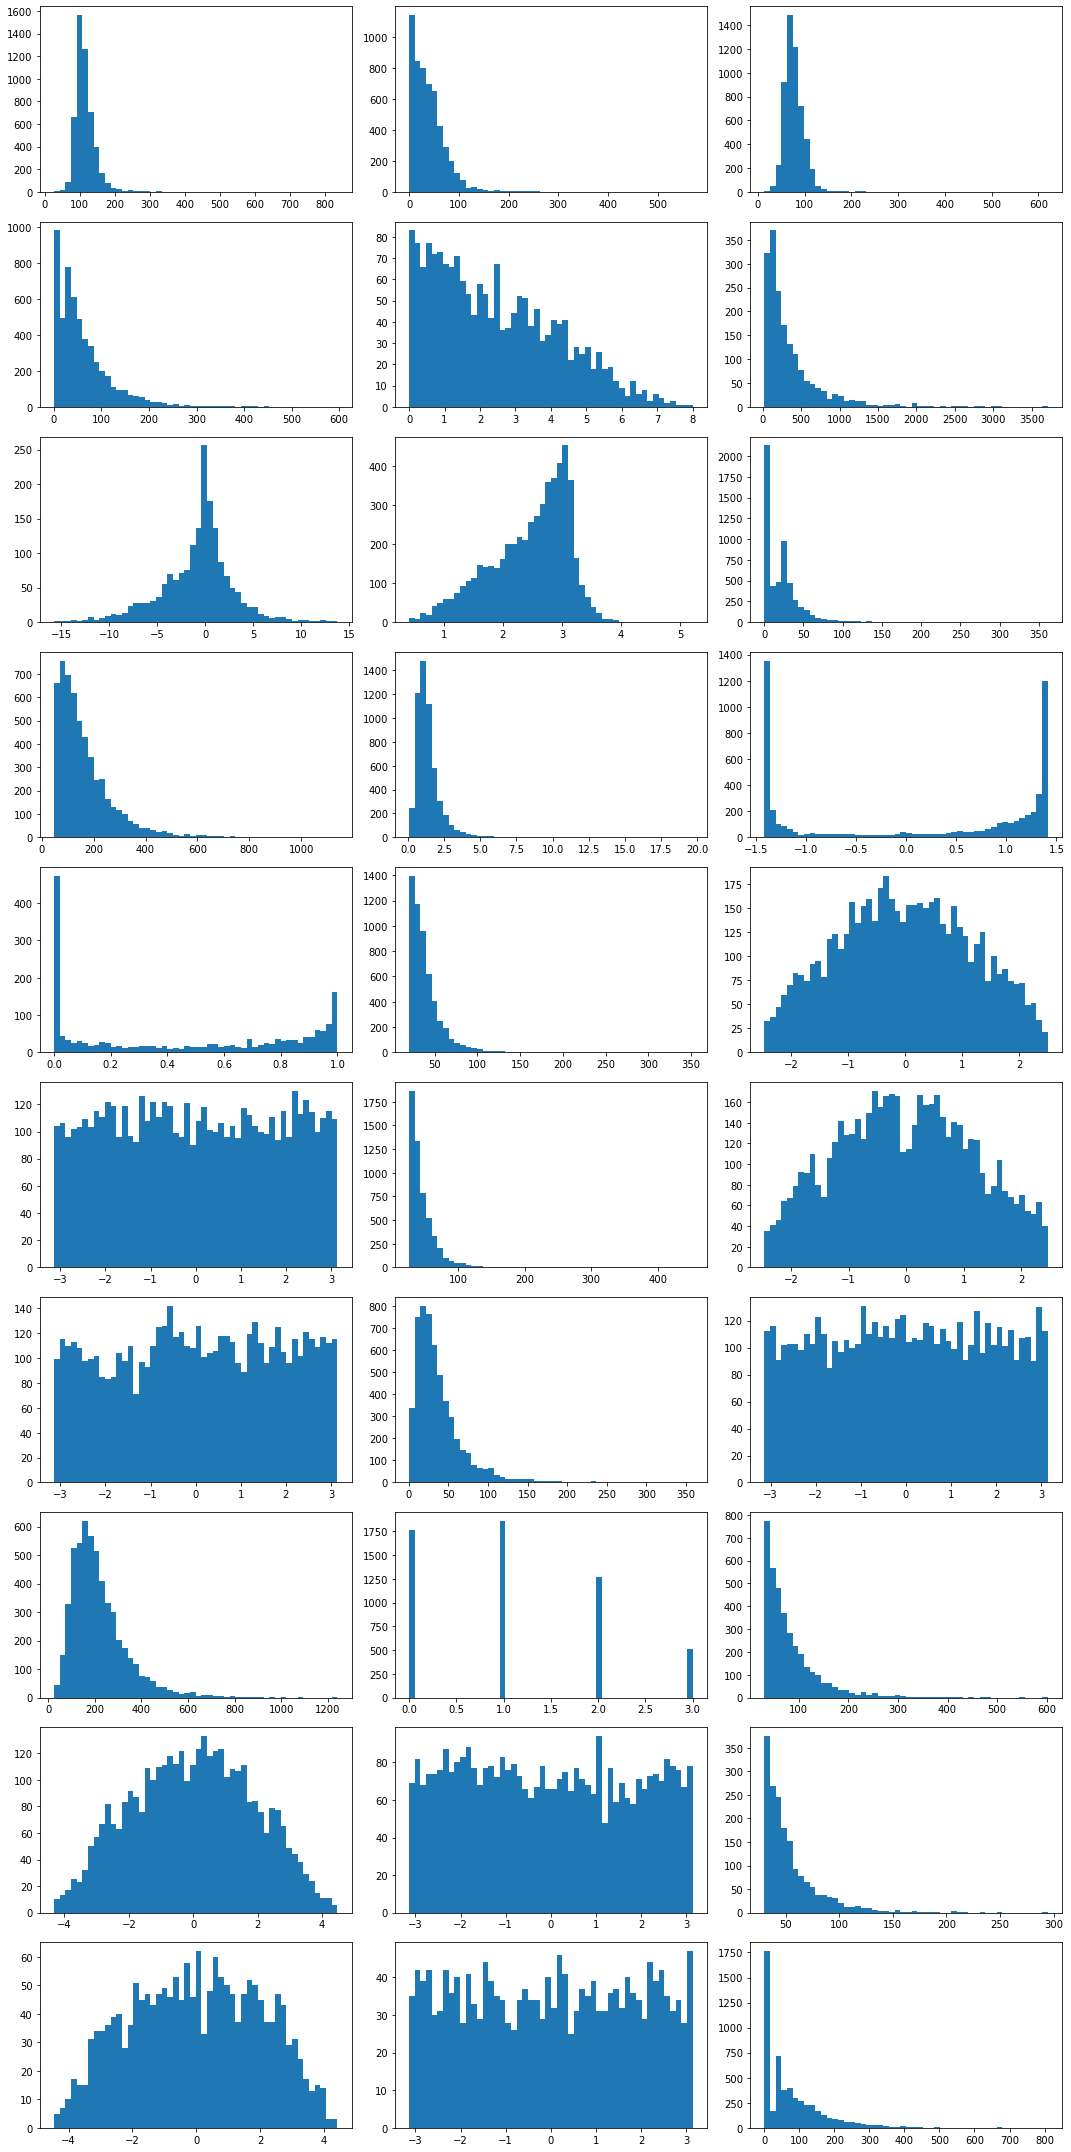

In [49]:
metrics_one, params_one = train(X_train_one, y_train_one, X_test_one)

In [50]:
metrics_many, params_many = train(X_train_many, y_train_many, X_test_many)

(568238, 24)

In [51]:
metrics_zero, params_zero

({'loss': 0.3733214337272306,
  'accuracy': 83.60318684142894,
  'f1_score': 0.6386998167125397},
 {'max_iters': 500,
  'degree': 3,
  'gamma': 0.1,
  'cont_features': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)})

In [52]:
metrics_one, params_one

({'loss': 0.4457033602770949,
  'accuracy': 79.5793524416136,
  'f1_score': 0.7025264276119368},
 {'max_iters': 500,
  'degree': 3,
  'gamma': 0.1,
  'cont_features': (1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22)})

In [53]:
metrics_many, params_many

({'loss': 0.41223637470071706,
  'accuracy': 81.87794749067362,
  'f1_score': 0.7993919206124159},
 {'max_iters': 500,
  'degree': 3,
  'gamma': 0.1,
  'cont_features': (1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29)})

In [54]:
a = X_train_zero.shape[0]
b =  X_train_one.shape[0] 
c = X_train_many.shape[0]
avg_accuracy = ((metrics_zero['accuracy']*a) +  (metrics_one['accuracy']*b) + (metrics_many['accuracy']*c))/(a+b+c)

print(f"Average accuracy with jet_num training is {avg_accuracy}")

Average accuracy with jet_num training is 81.85447382974445
